In [12]:
from simple_pid import PID

In [197]:
hourly_growth_rate = 0.12

def simulation(pid_params, duration_m=60*12, init_OD=1.0, target=None, volume=2):
    pid = PID(*pid_params, output_limits=(0, 1), sample_time=None)
    pid.setpoint = target
    OD_state = []
    OD = init_OD
    
    for i in range(duration_m):
        OD *= np.exp(hourly_growth_rate / 60)
        
        if (i % 30 == 0) and i > 0:
            output = pid(OD, dt=30)
            OD *= (1-(output * volume ) / 14)
            
    
        OD_state.append(OD)

    return OD_state

def score(OD_state, target):
    return ((np.array([OD_state[i] for i in 30 * np.arange(1, 24) - 1]) - target)**2).sum()


def simulate_and_score(pid_params, duration_m=60*12, init_OD=1.0, target=None,  volume=2):
    return score(simulation(pid_params, duration_m, init_OD, target, volume), target)


In [198]:
from autograd import grad

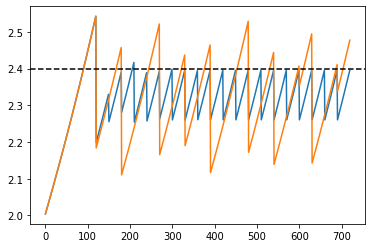

In [205]:
duration_m = 60 * 12
setpoint = 2.4
init_OD = 2.
volume=2
t = np.arange(duration_m)


y = simulation([-2, -0.15, -0], duration_m, target=setpoint, init_OD=init_OD, volume=volume)
plt.plot(t, y)


y = simulation([-10, -0.15, -0], duration_m, target=setpoint, init_OD=init_OD, volume=volume)
plt.plot(t, y)

plt.axhline(setpoint, c="k", ls="--")

In [206]:
grad(simulate_and_score)([-10., -0.15, -0.], duration_m=duration_m, target=setpoint, init_OD=init_OD, volume=2)

[array(0.01144945), array(0.54589625), array(0.0013079)]

In [233]:
from scipy.optimize import minimize, basinhopping

In [250]:
duration_m = 60 * 12
setpoint = 3.0
init_OD = 3.5
volume=1.5

results = basinhopping(
    simulate_and_score,
    x0 = (-2, -0.15, -0),
    niter=20,
    minimizer_kwargs = {
        "jac": grad(simulate_and_score),
        "args": (duration_m, init_OD, setpoint, volume),
        "bounds": [(None, 0), (None, 0), (None, 0)]
    }
)

/Users/camerondavidson-pilon/venvs/data/lib/python3.8/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


0.9581077037170225
0.9551203807238111


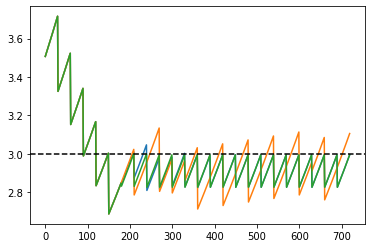

In [251]:
t = np.arange(duration_m)


y = simulation([-2, -0.15, -0], duration_m, target=setpoint, init_OD=init_OD, volume=volume)
print(score(y, setpoint))
plt.plot(t, y)


y = simulation([-10, -0.15, -0], duration_m, target=setpoint, init_OD=init_OD, volume=volume)
plt.plot(t, y)

y = simulation(results.x, duration_m, target=setpoint, init_OD=init_OD, volume=volume)
print(score(y, setpoint))

plt.plot(t, y)

plt.axhline(setpoint, c="k", ls="--")

In [252]:
results

                        fun: 0.9551203807238111
 lowest_optimization_result:       fun: 0.9551203807238111
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.42386075e-06,  2.77975554e-07,  1.80783082e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 17
      nit: 14
     njev: 17
   status: 0
  success: True
        x: array([-2.96914403, -0.11073067, -0.0863104 ])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 1221
                        nit: 20
                       njev: 1221
                          x: array([-2.96914403, -0.11073067, -0.0863104 ])